# Load Drone Model

In [1]:
import torch
import torch.nn as nn
from analyze import *

model = nn.Sequential(
    nn.Linear(11, 45, bias=True),
    nn.ReLU(),
    nn.Linear(45, 45, bias=True),
    nn.ReLU(),
    nn.Linear(45, 3, bias=True),
    nn.Sigmoid()
)

# load ThrustDragModel.pth
model.load_state_dict(torch.load('ThrustDragModel.pth'))  # Load the saved state_dict
model.eval()  # Set the model to evaluation mode
print(model)

# test model with random input
input = torch.rand(11)
output = model(input)
print('input:', input)
print('output:', output)

Sequential(
  (0): Linear(in_features=11, out_features=45, bias=True)
  (1): ReLU()
  (2): Linear(in_features=45, out_features=45, bias=True)
  (3): ReLU()
  (4): Linear(in_features=45, out_features=3, bias=True)
  (5): Sigmoid()
)
input: tensor([0.3461, 0.7985, 0.4166, 0.5613, 0.7360, 0.1409, 0.3195, 0.2905, 0.9306,
        0.1375, 0.6786])
output: tensor([0.3998, 0.4599, 0.8825], grad_fn=<SigmoidBackward0>)


/tmp/ipykernel_656572/295981442.py:15: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('ThrustDragModel.pth'))  # Load the saved state_dict


In [2]:
def get_modeled_acceleration(vbx, vby, vbz, omega0, omega1, omega2, omega3, p, q, r, ax, ay, az):
    # input tensor
    input_tensor = torch.tensor([az, p, q, r, vbx, vby, vbz, omega0, omega1, omega2, omega3], dtype=torch.float32)
    # normalize inputs
    input_tensor[0] = input_tensor[0] / 50          # az
    input_tensor[1:4] = input_tensor[1:4] / 10      # p, q, r
    input_tensor[4:7] = input_tensor[4:7] / 10      # vbx, vby, vbz
    input_tensor[7:11] = input_tensor[7:11] / 3000  # omega0, omega1, omega2, omega3
    # get the output tensor
    output_tensor = model(input_tensor)
    # the output is: z-bias, k_x, k_y
    z_bias_scaled = output_tensor[0]
    z_bias = (2*z_bias_scaled - 1)*2
    k_x = output_tensor[1]
    k_y = output_tensor[2]
    # get modeled acceleration
    ax_model = -k_x * vbx
    ay_model = -k_y * vby
    az_model = az + z_bias
    # return ax_model, ay_model, az_model as np.array
    output = np.array([ax_model.item(), ay_model.item(), az_model.item()])
    return output

# test get_modeled_acceleration with random input
print(get_modeled_acceleration(0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.1, 0, 0))

[-0.04469422 -0.13402294 -0.17259765]


# Generate C code

In [3]:
# convert the model into nn.Sequential
network = model

print('NETWORK:')
print(network)

NETWORK:
Sequential(
  (0): Linear(in_features=11, out_features=45, bias=True)
  (1): ReLU()
  (2): Linear(in_features=45, out_features=45, bias=True)
  (3): ReLU()
  (4): Linear(in_features=45, out_features=3, bias=True)
  (5): Sigmoid()
)


In [7]:
import torch
import torch.nn as nn
import os
import subprocess

# remove the c_code folder and all of its contents
subprocess.call('rm -rf c_code', shell=True)
# create a new c_code folder
subprocess.call('mkdir c_code', shell=True)

output_folder = "c_code"

# Generate the C file and the header file inside the "c_code" folder
source_file_path = os.path.join(output_folder, "drone_model.c")
header_file_path = os.path.join(output_folder, "drone_model.h")

# np.float32 to str
float_to_str = lambda x: str(float(x))

# Generate the C file
with open(source_file_path, "w") as file:
    file.write('#include "drone_model.h"\n')
    file.write("#include <stdio.h>\n")
    file.write("#include <math.h>\n\n")

    # modeled acceleration set to zero
    file.write("float ax_modeled = 0;\n")
    file.write("float ay_modeled = 0;\n")
    file.write("float az_modeled = 0;\n\n")
    
    # Define weights and biases as global constant float arrays
    i = 1
    for layer in network:
        if isinstance(layer, nn.Linear):
            weights_layer = layer.weight.data.cpu().numpy()
            biases_layer = layer.bias.data.cpu().numpy()

            file.write(f"static const float weights_fc{i}[] = {{\n")
            file.write(",\n".join([", ".join(map(float_to_str, row)) for row in weights_layer]))
            file.write("\n};\n\n")

            file.write(f"static const float biases_fc{i}[] = {{\n")
            file.write(", ".join(map(float_to_str, biases_layer)))
            file.write("\n};\n\n")

            i+=1

    # LINEAR LAYER
    file.write("static  void nn_linear(const float* weights, const float* biases, const float* input, int in_features, int out_features, float* output) {\n")
    file.write("    for (int i = 0; i < out_features; ++i) {\n")
    file.write("        float neuron = biases[i];\n")
    file.write("        for (int j = 0; j < in_features; ++j) {\n")
    file.write("            neuron += input[j] * weights[i * in_features + j];\n")
    file.write("        }\n")
    file.write("        output[i] = neuron;\n")
    file.write("    }\n")
    file.write("}\n\n")

    # RELU LAYER
    file.write("static void nn_relu(float* input, int size) {\n")
    file.write("    for (int i = 0; i < size; ++i) {\n")
    file.write("        input[i] = fmaxf(0, input[i]);\n")
    file.write("    }\n")
    file.write("}\n\n")

    # TANH LAYER
    # file.write("static void nn_tanh(float* input, int size) {\n")
    # file.write("    for (int i = 0; i < size; ++i) {\n")
    # file.write("        input[i] = tanh(input[i]);\n")
    # file.write("    }\n")
    # file.write("}\n\n")
    
    # SIGMOID LAYER
    file.write("static void nn_sigmoid(float* input, int size) {\n")
    file.write("    for (int i = 0; i < size; ++i) {\n")
    file.write("        input[i] = 1 / (1 + exp(-input[i]));\n")
    file.write("    }\n")
    file.write("}\n\n")

    # FORWARD FUNCTION
    file.write("static void nn_forward(const float* input, float* output) {\n")
    layer_size = network[0].out_features
    num_layers = sum(isinstance(layer, nn.Linear) for layer in network)
    i=0
    input_array = "input"
    for layer in network:
        if isinstance(layer, nn.Linear):
            i+=1
            if i<num_layers:
                file.write(f"    float fc{i}_output[{layer.out_features}];\n")
                file.write(f"    nn_linear(weights_fc{i}, biases_fc{i}, {input_array}, {layer.in_features}, {layer.out_features}, fc{i}_output);\n")
                input_array = f"fc{i}_output"
            else:
                file.write(f"    nn_linear(weights_fc{i}, biases_fc{i}, {input_array}, {layer.in_features}, {layer.out_features}, output);\n")
                input_array = "output"
            layer_size = layer.out_features
        elif isinstance(layer, nn.ReLU):
            file.write(f"    nn_relu({input_array}, {layer_size});\n")
        elif isinstance(layer, nn.Tanh):
            file.write(f"    nn_tanh({input_array}, {layer_size});\n")
        elif isinstance(layer, nn.Sigmoid):
            file.write(f"    nn_sigmoid({input_array}, {layer_size});\n")
        else:
            raise Exception(f"Unsupported layer: {layer}")
    file.write("}\n")
    
    # COMPUTE MODELED ACCELERATION FUNCTION
    file.write("void compute_modeled_acceleration(float vbx, float vby, float vbz,\n")
    file.write("                          float omega0, float omega1, float omega2, float omega3,\n")
    file.write("                          float p, float q, float r, float ax_measured, float ay_measured, float az_measured\n")
    file.write(") {\n")
    file.write("    // let compiler know which variables are not used \n")
    file.write("    (void) ax_measured;\n")
    file.write("    (void) ay_measured;\n\n")
    file.write("    // neural network input\n")
    file.write("    float input[] = {az_measured, p, q, r, vbx, vby, vbz, omega0, omega1, omega2, omega3};\n")
    file.write("    // normalize inputs\n")
    file.write("    input[0] = input[0] / 50;           // az\n")
    file.write("    for (int i = 1; i < 4; ++i) {\n")
    file.write("        input[i] = input[i] / 10;       // p, q, r\n")
    file.write("    }\n")
    file.write("    for (int i = 4; i < 7; ++i) {\n")
    file.write("        input[i] = input[i] / 10;       // vbx, vby, vbz\n")
    file.write("    }\n")
    file.write("    for (int i = 7; i < 11; ++i) {\n")
    file.write("        input[i] = input[i] / 3000;     // omega0, omega1, omega2, omega3\n")
    file.write("    }\n")
    file.write("    // neural network output\n")
    file.write("    float output[3];\n")
    file.write("    // run the neural network\n")
    file.write("    nn_forward(input, output);\n")
    file.write("    // process the output\n")
    file.write("    float z_bias_scaled = output[0];\n")
    file.write("    float z_bias = (2*z_bias_scaled - 1)*2;\n")
    file.write("    float k_x = output[1];\n")
    file.write("    float k_y = output[2];\n")
    file.write("    // get modeled acceleration\n")
    file.write("    ax_modeled = -k_x * vbx;\n")
    file.write("    ay_modeled = -k_y * vby;\n")
    file.write("    az_modeled = az_measured + z_bias;\n")
    file.write("}\n\n")
    
    # GET MODELED ACCELERATION FUNCTION
    file.write("void get_modeled_acceleration(float *ax, float *ay, float *az) {\n")
    file.write("    *ax = ax_modeled;\n")
    file.write("    *ay = ay_modeled;\n")
    file.write("    *az = az_modeled;\n")
    file.write("}\n") 

# Generate the header file
with open(header_file_path, "w") as header_file:
    header_file.write("#ifndef DRONE_MODEL_H\n")
    header_file.write("#define DRONE_MODEL_H\n\n")
    header_file.write("void compute_modeled_acceleration(float vbx, float vby, float vbz,\n")
    header_file.write("                          float omega0, float omega1, float omega2, float omega3,\n")
    header_file.write("                          float p, float q, float r, float ax_measured, float ay_measured, float az_measured\n")
    header_file.write(");\n\n")
    header_file.write("void get_modeled_acceleration(float *ax, float *ay, float *az);\n\n")
    header_file.write("#endif // DRONE_MODEL_H\n")


# Print the generated files
# Print the generated files
print(f"Generated {source_file_path}")
print(f"Generated {header_file_path}")

Generated c_code/drone_model.c
Generated c_code/drone_model.h


# Test the C code

In [8]:
import os
import subprocess
import ctypes
import numpy as np
import importlib
importlib.reload(ctypes)

# https://cu7ious.medium.com/how-to-use-dynamic-libraries-in-c-46a0f9b98270
path = os.path.abspath('c_code')
# Create object files
subprocess.call('gcc -fPIC -c *.c', shell=True, cwd=path)
# Create library
subprocess.call('gcc -shared -Wl,-soname,libtools.so -o libtools.so *.o', shell=True, cwd=path)
# Remove object files
subprocess.call('rm *.o', shell=True, cwd=path)

lib_path = os.path.abspath("c_code/libtools.so")
fun = ctypes.CDLL(lib_path)

# define argument types 
fun.compute_modeled_acceleration.argtypes = [ctypes.c_float]*13
fun.get_modeled_acceleration.argtypes = [ctypes.POINTER(ctypes.c_float)]*3

# get python function to call the C function
def get_modeled_acceleration_c_code(vbx, vby, vbz, omega0, omega1, omega2, omega3, p, q, r, ax, ay, az):
    fun.compute_modeled_acceleration(vbx, vby, vbz, omega0, omega1, omega2, omega3, p, q, r, ax, ay, az)
    ax = ctypes.c_float()
    ay = ctypes.c_float()
    az = ctypes.c_float()
    fun.get_modeled_acceleration(ctypes.byref(ax), ctypes.byref(ay), ctypes.byref(az))
    return ax.value, ay.value, az.value

# check if get_modeled_acceleration_c_code gives the same result as get_modeled_acceleration
print(get_modeled_acceleration(0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.1, 0, 0))
print(get_modeled_acceleration_c_code(0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.1, 0, 0))

[-0.04469422 -0.13402294 -0.17259765]
(-0.04469422250986099, -0.13402292132377625, -0.1725977659225464)


Loading flight_data/Okt25_Dummy_fig8_normal.csv
Logging frequency: 471.0933436319762


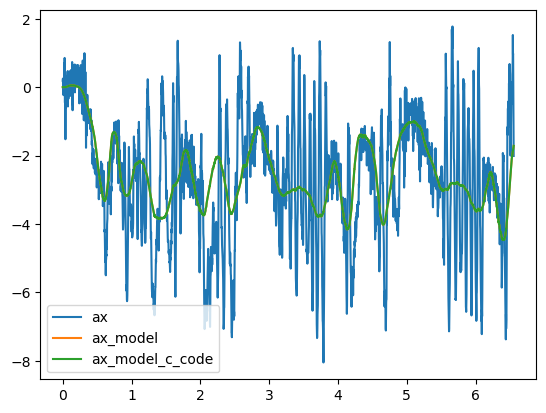

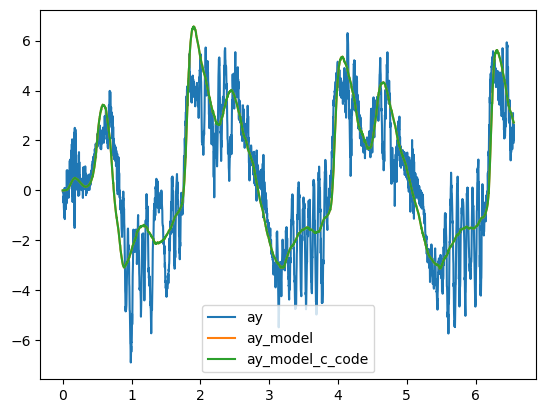

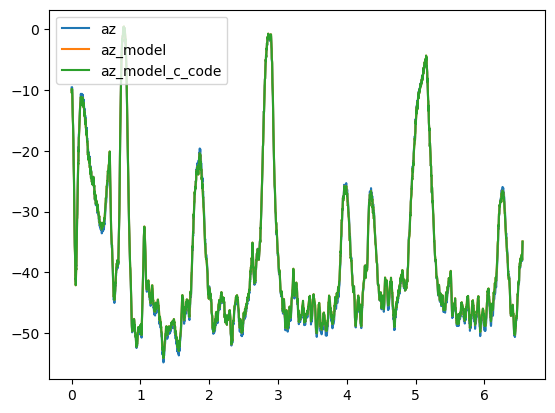

In [9]:
data = load_flight_data('flight_data/Okt25_Dummy_fig8_normal.csv')
data = trim_nn_active(data)

# get az, p, q, r, vbx, vby, vbz, omega0, omega1, omega2, omega3
model_input = np.array([
    data[key] for key in ['vbx', 'vby', 'vbz', 'omega[0]', 'omega[1]', 'omega[2]', 'omega[3]', 'p', 'q', 'r', 'ax', 'ay', 'az']
]).T

# get modeled acceleration
modeled_acceleration = np.array([
    get_modeled_acceleration(*input) for input in model_input
])

# get modeled acceleration with C code
modeled_acceleration_c_code = np.array([
    get_modeled_acceleration_c_code(*input) for input in model_input
])

# plot acceleration and modeled acceleration
plt.plot(data['t'], data['ax'], label='ax')
plt.plot(data['t'], modeled_acceleration[:, 0], label='ax_model')
plt.plot(data['t'], modeled_acceleration_c_code[:, 0], label='ax_model_c_code')
plt.legend()
plt.show()

plt.plot(data['t'], data['ay'], label='ay')
plt.plot(data['t'], modeled_acceleration[:, 1], label='ay_model')
plt.plot(data['t'], modeled_acceleration_c_code[:, 1], label='ay_model_c_code')
plt.legend()
plt.show()

plt.plot(data['t'], data['az'], label='az')
plt.plot(data['t'], modeled_acceleration[:, 2], label='az_model')
plt.plot(data['t'], modeled_acceleration_c_code[:, 2], label='az_model_c_code')
plt.legend()
plt.show()